In [1]:
pip install pydicom

     |████████████████████████████████| 7.0MB 3.4MB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [5]:
!ls

 Classfiication_Report.ipynb
'Copy of RSNA_Classification_Chexnet_and_EDA.ipynb'
 Crop
 first_try_1.h5
 pneumonia
 RSNA_basemodel.ipynb
 RSNA_Classification_Chexnet_and_EDA.ipynb
 RSNA_EDA_crop.ipynb
 stage_2_detailed_class_info.csv
 stage_2_train_labels.csv
 test
 train
 training
 Validation


In [0]:
detail_class_path = '/content/drive/My Drive/Colab Notebooks/stage_2_detailed_class_info.csv'
bbox_path = '/content/drive/My Drive/Colab Notebooks/stage_2_train_labels.csv'
dicom_dir = '/content/drive/My Drive/Colab Notebooks/stage_2_train_images/'

In [7]:
detailed_class_df = pd.read_csv(detail_class_path)
print('No of samples in deatiled class:',detailed_class_df.shape[0])

bbox_df=pd.read_csv(bbox_path)
print('No of samples in bounding box dataframe:',bbox_df.shape[0])
#print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')

No of samples in deatiled class: 30227
No of samples in bounding box dataframe: 30227


In [8]:
detailed_class_df.sample(10)

,patientId,class
15681,98d086ab-0122-4c61-9b4b-a41ffc1a469b,Normal
22514,cb815f3a-5014-4bbe-9e34-828149ba9f6e,Lung Opacity
28636,fd49c13b-5627-4ee1-9b61-54013d8f1fd9,Normal
12765,818c3ac1-b27c-4d9e-8849-f97127647c97,No Lung Opacity / Not Normal
2744,33dea6c5-2f2c-4164-a489-8ae440b921f1,Lung Opacity
13901,8ab8dfdb-1afe-4e18-8a75-e6ac7ebc3fae,No Lung Opacity / Not Normal
20798,bd7b4e6e-5384-4cce-9732-0dd7f9d15da8,Lung Opacity
20865,bdd44f36-4634-44d1-b90f-3cbc8dc639f1,Lung Opacity
23119,d057a076-1711-4c17-92ea-7cfcc2209788,No Lung Opacity / Not Normal
5535,477cd50b-52f1-4994-871b-91cf32fa3174,No Lung Opacity / Not Normal


In [9]:
bbox_df.sample(10)

,patientId,x,y,width,height,Target
5809,49cda5b8-d41d-4b34-b25b-b92520b65ea5,NaN,NaN,NaN,NaN,0
28305,faa193f7-eeab-4acd-bc73-72208df5dd72,NaN,NaN,NaN,NaN,0
10647,70db87e6-4e7c-4afe-8bd9-a6870c67aee5,NaN,NaN,NaN,NaN,0
10146,6cd8ee4e-60ef-484e-b242-93009537142e,NaN,NaN,NaN,NaN,0
17586,a7b5d4ff-840c-4db3-bf4a-d5c71b49f754,NaN,NaN,NaN,NaN,0
35,019ca122-9cdf-4704-b7a9-449c8a1c263e,NaN,NaN,NaN,NaN,0
11844,7a10efd9-178c-485c-b1e3-605298a5bc76,NaN,NaN,NaN,NaN,0
2996,356ed546-ec57-4502-8fb9-1a9b48b6d83f,NaN,NaN,NaN,NaN,0
20968,be83eb42-e7de-44f3-b853-a4faee9c871c,NaN,NaN,NaN,NaN,0
20749,bd1356ed-d7fc-41d7-a11b-b1b1f2c5add1,138.0,79.0,274.0,591.0,1


In [0]:
bbox_df['duplicate'] = bbox_df.duplicated(['patientId'], keep=False)

In [11]:
bbox_df.head(10)

,patientId,x,y,width,height,Target,duplicate
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,False
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,False
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,False
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,False
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,True
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,False
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,False
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,True
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,True


In [0]:
tmp_normal=bbox_df[(bbox_df['duplicate'] == False) &( bbox_df['Target']==0)]

In [13]:
tmp_normal.shape

(20672, 7)

In [0]:
list_normal_patients=tmp_normal['patientId'].sample(500)

In [15]:
len(list_normal_patients)

500

In [0]:
tmp2_pneumonia=bbox_df[(bbox_df['duplicate'] == True) &( bbox_df['Target']==1)]

In [17]:
tmp2_pneumonia.shape

(6941, 7)

In [0]:
list_pneumonia_patients=tmp2_pneumonia['patientId'].sample(500)

In [19]:
len(list_pneumonia_patients)

500

In [0]:
tmp3=bbox_df[(bbox_df['duplicate'] == False) &( bbox_df['Target']==1)]

In [21]:
tmp3.shape

(2614, 7)

In [0]:
train_class_df = detailed_class_df.merge(bbox_df, left_on='patientId', right_on='patientId', how='inner')

In [23]:
train_class_df.head(40)

,patientId,class,x,y,width,height,Target,duplicate
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,False
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
8,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False


In [24]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(detailed_class_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


In [25]:
#get_feature_distribution(bbox_df, 'Target')
bbox_df['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [26]:
train_class_df.head(10)

,patientId,class,x,y,width,height,Target,duplicate
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,False
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
8,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,False


In [27]:
pneumonia_patients=train_class_df[train_class_df.Target != 0]
# Sort by patientId
pneumonia_patients.groupby(['patientId'], sort=False)
pneumonia_patients.head()

,patientId,class,x,y,width,height,Target,duplicate
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,True
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,True
10,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,323.0,577.0,160.0,104.0,1,True


In [28]:
pneumonia_patients.shape

(16957, 8)

In [29]:
pneumonia_patients['class'].value_counts()

Lung Opacity    16957
Name: class, dtype: int64

In [30]:
any(pneumonia_patients['patientId'].duplicated())

True

In [0]:
gt=train_class_df.groupby('patientId',as_index=False)['Target'].max()

In [32]:
gt.shape

(26684, 2)

In [33]:
gt.sample(10)

,patientId,Target
2644,2bcd9659-31d3-4e71-aca6-6b7defbb5b3d,0
11904,7eb0abcb-860e-4745-b311-28657770c038,1
6336,4ef41ff0-2671-4b4d-8492-90aad883e126,0
9742,6bf5b78a-635b-48f2-b767-460711927d7f,0
974,0bf374b1-dd39-4549-b573-6e69af4dd0e9,0
24379,ec3bdec5-13df-49c0-862a-c8dd8124bfce,0
8776,6448b83f-acd4-4ec5-94ca-fa76bd04a9cd,0
12994,88d25c7b-029a-484e-b860-284e164422cf,1
5721,499d40ec-e646-4e4b-a864-a95f47b10413,0
10399,7181705d-bd1b-4896-94e6-0cc4d7562d56,1


In [34]:
type(gt)

pandas.core.frame.DataFrame

In [35]:
gt['Target'].value_counts()

0    20672
1     6012
Name: Target, dtype: int64

In [36]:
train_class_df['patientId'].nunique()

26684

In [37]:
train_class_df.shape

(37629, 8)

In [38]:
detailed_class_df.shape

(30227, 2)

In [39]:
bbox_df.shape

(30227, 7)

Lets check if any null values in both the dataframes

In [40]:
print(detailed_class_df.isna().sum())

patientId    0
class        0
dtype: int64


In [41]:
print(bbox_df.isna().sum())

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
duplicate        0
dtype: int64


In [42]:
import os
# Keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


In [0]:
train_directory="/content/drive/My Drive/Colab Notebooks/train/"
validate_samples = 2560

In [44]:
filenames = os.listdir(train_directory)
print(len(filenames))

OSError: ignored

In [0]:

train_filenames= filenames[validate_samples:]
#validate_filenames= filenames[:validate_samples]
train_filenames_lenght=len(train_filenames)
#validate_filenames_lenght=len(validate_filenames)

In [0]:
#converting dicom to png images
import cv2
import os
import pydicom

inputdir = '/content/drive/My Drive/Colab Notebooks/train/'
outdir = '/content/drive/My Drive/Colab Notebooks/pneumonia/'

if(os.path.exists(outdir)== False):
  print('Creating out dir')
  os.mkdir(outdir)




In [0]:
for f in list_pneumonia_patients :   # remove "[:10]" to convert all images 
    ds = pydicom.read_file(inputdir + f+'.dcm') # read dicom image
    img = ds.pixel_array # get image array
    name = inputdir + f+'.dcm'
    print(name)
    newname= outdir+f+'.png'
    print(newname)
    
    status =cv2.imwrite(newname,img) # write png image
    print("Image written to file-system : ",status)

In [0]:
outdir = '/content/drive/My Drive/Colab Notebooks/normal/'

if(os.path.exists(outdir)== False):
  print('Creating out dir')
  os.mkdir(outdir)

for f in list_normal_patients :   # remove "[:10]" to convert all images 
    ds = pydicom.read_file(inputdir + f+'.dcm') # read dicom image
    img = ds.pixel_array # get image array
    name = inputdir + f+'.dcm'
    print(name)
    newname= outdir+f+'.png'
    print(newname)
    status=cv2.imwrite(newname,img) # write png image
    print("Image written to file-system : ",status)

In [0]:
from keras.preprocessing.image import  img_to_array, load_img
WIDTH = 128
HEIGHT = 128
DEPTH = 3

In [0]:
import os
import cv2 

data = []
labels = []

patientID=[]
filename=[]

trainDir = '/content/drive/My Drive/Colab Notebooks/training/'
#outdir = '/content/drive/My Drive/Colab Notebooks/pneumonia/'
#trainDir= '/content/drive/My Drive/Colab Notebooks/data'
# loop over the input images
dirs = os.listdir(trainDir) 
for dir in dirs:
    absDirPath = os.path.join(os.path.sep,trainDir, dir)
    images = os.listdir(absDirPath)
    for imageFileName in images:
        
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(trainDir, dir, imageFileName)
        #print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  #Numpy array with shape (233,233,3)
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape)
        data.append(arr)
        patientID.append(imageFileName.split('/')[-1].split('.')[0])
        filename.append(imageFullPath)
        #label = classes_to_int(dir)
        if(dir== 'pneumonia'):
          label=1
        else:
          label=0
        #print(label)
        labels.append(label)

In [47]:
print(len(images))
print('Number of images :-',len(data))
print('Number of Labels',len(labels))
print('Number of patientID :-',len(patientID))
print(len(filename))

2460
Number of images :- 4169
Number of Labels 4169
Number of patientID :- 4169
4169


In [0]:
out_df = pd.DataFrame({'patientId':patientID , 
                       'images':data,
                        'Labels': labels,
                         'Filenames':filename})

In [49]:
out_df['images'].head(5)

0    [[[152.0, 152.0, 152.0], [174.75, 174.75, 174....
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[13.5, 13.5, 13.5], [11.5, 11.5, 11.5], [12....
3    [[[161.75, 161.75, 161.75], [150.5, 150.5, 150...
4    [[[3.75, 3.75, 3.75], [4.0, 4.0, 4.0], [3.25, ...
Name: images, dtype: object

In [50]:
out_df.head(3)

,patientId,images,Labels,Filenames
0,3a146de9-9044-4abc-b15c-e7e0d18a0704,"[[[152.0, 152.0, 152.0], [174.75, 174.75, 174....",1,/content/drive/My Drive/Colab Notebooks/traini...
1,bc9683bf-595d-497e-8c99-ac9baed1a2eb,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",1,/content/drive/My Drive/Colab Notebooks/traini...
2,bab8d182-b9fe-4db9-88b5-042153c4406e,"[[[13.5, 13.5, 13.5], [11.5, 11.5, 11.5], [12....",1,/content/drive/My Drive/Colab Notebooks/traini...


In [0]:
TrainX = np.array(data, dtype="float") / 255.0
Y_labels = np.array(labels)

In [0]:
# partition the data into training and validation splits 

from sklearn.model_selection import train_test_split

(x_train, valX, y_train, valY) = train_test_split(TrainX,Y_labels,test_size=0.20, random_state=10)

In [53]:
out_df['Filenames'].head(5)

0    /content/drive/My Drive/Colab Notebooks/traini...
1    /content/drive/My Drive/Colab Notebooks/traini...
2    /content/drive/My Drive/Colab Notebooks/traini...
3    /content/drive/My Drive/Colab Notebooks/traini...
4    /content/drive/My Drive/Colab Notebooks/traini...
Name: Filenames, dtype: object

In [0]:
detailed_class_df.dtypes

In [0]:
#out_df.merge(detailed_class_df,left_on='patientId', right_on'patientId')

In [54]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=out_df, x_col="Filenames", y_col="Labels", 
                                            class_mode="other", target_size=(32,32), batch_size=32)

Found 4169 validated image filenames.


In [61]:
from keras import backend as k
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.optimizers import Adam
# initialize the model

import sys

sys.stdout.flush()
k.clear_session()

inputShape = (WIDTH, HEIGHT, DEPTH)
EPOCHS = 40
INIT_LR = 1e-3
BS = 32

model = Sequential()
model.add(Conv2D(1024, (3, 3), padding="same", input_shape=inputShape)) 
model.add(Activation("relu"))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
#  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
#  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=500))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(units=1))
model.add(Activation("sigmoid"))
   
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 1024)    28672     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 1024)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 1024)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 512)       4719104   
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 512)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       1179904   
__________

In [62]:
# train the network

sys.stdout.flush()

H = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BS), 
                        validation_data=(valX, valY), 
                        steps_per_epoch=len(x_train) // BS, 
                        epochs=EPOCHS, verbose=1)

Epoch 1/40
104/104 [==============================] - 58s 559ms/step - loss: 0.6804 - acc: 0.5874 - val_loss: 0.6827 - val_acc: 0.5935
Epoch 2/40
104/104 [==============================] - 51s 486ms/step - loss: 0.6781 - acc: 0.5886 - val_loss: 0.6840 - val_acc: 0.5935
Epoch 3/40
104/104 [==============================] - 48s 460ms/step - loss: 0.6789 - acc: 0.5865 - val_loss: 0.6738 - val_acc: 0.5935
Epoch 4/40
104/104 [==============================] - 48s 459ms/step - loss: 0.6775 - acc: 0.5893 - val_loss: 0.6768 - val_acc: 0.5935
Epoch 5/40
104/104 [==============================] - 48s 458ms/step - loss: 0.6781 - acc: 0.5889 - val_loss: 0.6753 - val_acc: 0.5935
Epoch 6/40
104/104 [==============================] - 47s 455ms/step - loss: 0.6756 - acc: 0.5951 - val_loss: 0.6748 - val_acc: 0.5935
Epoch 7/40
104/104 [==============================] - 47s 454ms/step - loss: 0.6771 - acc: 0.5907 - val_loss: 0.6749 - val_acc: 0.5935
Epoch 8/40
104/104 [==============================] - 4

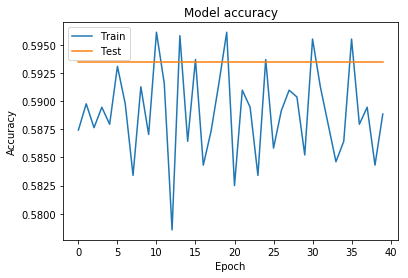

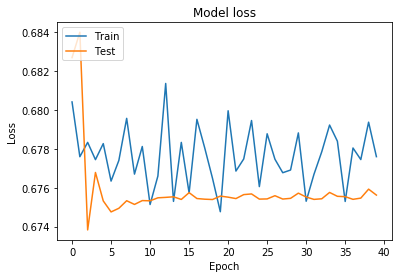

In [63]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [64]:
pred_Y = model.predict(valX, 
                          batch_size = BS, 
                          verbose = True)

834/834 [==============================] - 4s 5ms/step


In [69]:
type(pred_Y)

numpy.ndarray

In [78]:
pred_Y[0]

array([0.416304], dtype=float32)

In [0]:
preds=[]
for i in pred_Y:
  if i  >= 0.4:
    value=1
    preds.append(value)
      
    
  else :
    value=0
    preds.append(value)

In [81]:

from sklearn.metrics import confusion_matrix,classification_report
print("\nConfusion_Marix is :\n",confusion_matrix(valY, preds))
print("\nClassification_Report is :\n",classification_report(valY, preds))


Confusion_Marix is :
 [[  0 495]
 [  0 339]]

Classification_Report is :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.41      1.00      0.58       339

    accuracy                           0.41       834
   macro avg       0.20      0.50      0.29       834
weighted avg       0.17      0.41      0.23       834



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(classification_report(np.argmax(valY, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))